## Prediction of accident number by category and time
#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from neuralprophet import NeuralProphet, save, load
import itertools
import logging
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

/u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Load dataset
The number of accidents for different categories per month.

In [2]:
df = pd.read_csv('./data/monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      2016 non-null   object 
 1   AUSPRAEGUNG                     2016 non-null   object 
 2   JAHR                            2016 non-null   int64  
 3   MONAT                           2016 non-null   int64  
 4   WERT                            1848 non-null   float64
 5   VORJAHRESWERT                   1848 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 141.9+ KB


#### Data cleaning
Drop NaNs in "WERT".

In [3]:
df.dropna(axis=0, subset=['WERT'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      1848 non-null   object 
 1   AUSPRAEGUNG                     1848 non-null   object 
 2   JAHR                            1848 non-null   int64  
 3   MONAT                           1848 non-null   int64  
 4   WERT                            1848 non-null   float64
 5   VORJAHRESWERT                   1764 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 130.1+ KB


Check for duplicates.

In [5]:
print(df.duplicated().any())

False


Convert the format of "MONAT" to datetime.

In [4]:
df['MONAT'] = pd.to_datetime(df['MONAT'], format='%Y%m', errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   MONATSZAHL                      1848 non-null   object        
 1   AUSPRAEGUNG                     1848 non-null   object        
 2   JAHR                            1848 non-null   int64         
 3   MONAT                           1848 non-null   datetime64[ns]
 4   WERT                            1848 non-null   float64       
 5   VORJAHRESWERT                   1764 non-null   float64       
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64       
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64       
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 130.1+ KB


#### Data preprocessing
Split data into train and test set (train set: all data before 2020, test set: data after 2020).

In [13]:
data = df.copy()

data_train = data[data['MONAT'] < '2021-01-01']
data_train.reset_index(drop=True, inplace=True)
print(data_train.shape)

data_test = data[data['MONAT'] >= '2021-01-01']
data_test.reset_index(drop=True, inplace=True)
print(data_test.shape)
data_test.head()

(1764, 9)
(84, 9)


,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2021,2021-01-01,16.0,28.0,23.08,-42.86,35.0
1,Alkoholunfälle,insgesamt,2021,2021-02-01,14.0,40.0,-12.50,-65.00,33.0
2,Alkoholunfälle,insgesamt,2021,2021-03-01,24.0,27.0,71.43,-11.11,32.0
3,Alkoholunfälle,insgesamt,2021,2021-04-01,16.0,26.0,-33.33,-38.46,32.0
4,Alkoholunfälle,insgesamt,2021,2021-05-01,24.0,40.0,50.00,-40.00,30.0


Split data per category (Verkehrsunfälle, Alkoholunfälle, Fluchtunfälle).

In [74]:
data = df.copy()

data_alk = data[data['MONATSZAHL'] == 'Alkoholunfälle']
data_alk.reset_index(drop=True, inplace=True)
print(data_alk['AUSPRAEGUNG'].value_counts())
print(data_alk.shape)

data_flu = data[data['MONATSZAHL'] == 'Fluchtunfälle']
data_flu.reset_index(drop=True, inplace=True)
print(data_flu['AUSPRAEGUNG'].value_counts())
print(data_flu.shape)

data_ver = data[data['MONATSZAHL'] == 'Verkehrsunfälle']
data_ver.reset_index(drop=True, inplace=True)
print(data_ver['AUSPRAEGUNG'].value_counts())
print(data_ver.shape)

insgesamt                 264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(528, 9)
insgesamt                 264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(528, 9)
insgesamt                 264
mit Personenschäden       264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(792, 9)


Keep "WERT" and drop irrelevant columns.

In [6]:
data = df.copy()

data_wert = data[['MONATSZAHL', 'AUSPRAEGUNG', 'MONAT', 'WERT']]
data_wert.reset_index(drop=True, inplace=True)
data_wert.head()

,MONATSZAHL,AUSPRAEGUNG,MONAT,WERT
0,Alkoholunfälle,insgesamt,2021-01-01,16.0
1,Alkoholunfälle,insgesamt,2021-02-01,14.0
2,Alkoholunfälle,insgesamt,2021-03-01,24.0
3,Alkoholunfälle,insgesamt,2021-04-01,16.0
4,Alkoholunfälle,insgesamt,2021-05-01,24.0


#### Prediction of accident number by category and time
1. Univariate time series model (NeuralProphet).

A Univariate time series model takes only two inputs: the datetime and the variable. Further process the dataset to fulfill this constrain.

In [5]:
data = df.copy()

data_grouped = data.groupby(['MONATSZAHL', 'AUSPRAEGUNG'])

df_names = ['data_alk_ins', 'data_alk_vug', 'data_flu_ins', 'data_flu_vug', 'data_ver_ins', 'data_ver_mps', 'data_ver_vug']
df_list = []

for i in range(len(data.MONATSZAHL.unique())):
    data_tmp = data[data['MONATSZAHL'] == data.MONATSZAHL.unique()[i]]
    for j in range(len(data_tmp.AUSPRAEGUNG.unique())):
        data_tmp_2 = data_grouped.get_group((data.MONATSZAHL.unique()[i], data_tmp.AUSPRAEGUNG.unique()[j]))
        data_tmp_2.sort_values(by='MONAT', inplace=True, ascending=False)
        df_names[i+j] = data_tmp_2[['MONAT', 'WERT']]
        df_names[i+j].sort_values(by='MONAT', inplace=True, ascending=False)
        df_names[i+j].reset_index(drop=True, inplace=True)
        df_list.append(df_names[i+j])
        print(df_names[i+j].head())

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1057216/265285068.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tmp_2.sort_values(by='MONAT', inplace=True, ascending=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1057216/265285068.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names[i+j].sort_values(by='MONAT', inplace=True, ascending=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1057216/265285068.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

       MONAT  WERT
0 2021-12-01  21.0
1 2021-11-01  33.0
2 2021-10-01  43.0
3 2021-09-01  54.0
4 2021-08-01  46.0
       MONAT  WERT
0 2021-12-01   7.0
1 2021-11-01  15.0
2 2021-10-01  27.0
3 2021-09-01  36.0
4 2021-08-01  24.0
       MONAT    WERT
0 2021-12-01   788.0
1 2021-11-01   849.0
2 2021-10-01  1053.0
3 2021-09-01   951.0
4 2021-08-01   715.0
       MONAT  WERT
0 2021-12-01  17.0
1 2021-11-01  55.0
2 2021-10-01  52.0
3 2021-09-01  78.0
4 2021-08-01  41.0
       MONAT    WERT
0 2021-12-01  2997.0
1 2021-11-01  3308.0
2 2021-10-01  3861.0
3 2021-09-01  3651.0
4 2021-08-01  2857.0
       MONAT   WERT
0 2021-12-01  284.0
1 2021-11-01  368.0
2 2021-10-01  492.0
3 2021-09-01  594.0
4 2021-08-01  449.0
       MONAT   WERT
0 2021-12-01  340.0
1 2021-11-01  430.0
2 2021-10-01  561.0
3 2021-09-01  678.0
4 2021-08-01  531.0


Try with category "Alkoholunfälle" and type "insgesamt".

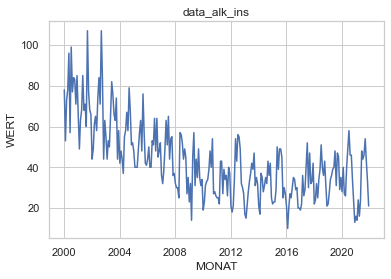

In [6]:
sns.set(rc={'figure.figsize':(8, 4)})
sns.set_style("whitegrid")

sns.lineplot(x='MONAT', y='WERT', data=df_list[0]).set_title('data_alk_ins')
plt.show()

Split data into train(<=2020) and test(>2020) set.

In [7]:
data = df_list[0].copy()
data.columns = ['ds', 'y']

data_train_val = data[data['ds'] < '2021-01-01']
data_train_val.reset_index(drop=True, inplace=True)
print(data_train_val.shape)
data_test = data[data['ds'] >= '2021-01-01']
data_test.reset_index(drop=True, inplace=True)
print(data_test.shape)

(252, 2)
(12, 2)


Train model.

In [12]:
model = NeuralProphet(yearly_seasonality='auto', seasonality_mode='additive', normalize='minmax')

data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.1)
print("Dataset size:", len(data))
print("Train dataset size:", len(data_train))
print("Validation dataset size:", len(data_val))

model = model.add_country_holidays(country_name='DE')
model.set_plotting_backend('plotly-static')
metrics_train = model.fit(data_train, validation_df=data_val, freq='MS', batch_size=3, epochs=300, early_stopping=False, learning_rate=0.008, progress=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.937% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.709% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CB

Dataset size: 264
Train dataset size: 227
Validation dataset size: 25


In [13]:
metrics_train

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,7294.927246,7314.024902,1.377016,0.0,0,4560.765137,4673.447266,1.171873,0.0
1,7143.587891,7163.199707,1.346893,0.0,1,4256.343262,4393.019531,1.076094,0.0
2,6993.453613,7013.732422,1.317009,0.0,2,3939.572266,4104.958008,0.977177,0.0
3,6840.671875,6861.645020,1.286599,0.0,3,3635.831299,3851.072266,0.882422,0.0
4,6687.946777,6709.735840,1.256200,0.0,4,3334.862061,3526.986816,0.788471,0.0
...,...,...,...,...,...,...,...,...,...
295,919.504700,1007.906555,0.112443,0.0,295,284.436279,336.583618,0.027216,0.0
296,920.221863,1008.531311,0.112565,0.0,296,284.019104,329.269135,0.027191,0.0
297,919.635315,1008.012756,0.112465,0.0,297,283.706940,332.155670,0.027158,0.0
298,919.451416,1007.851990,0.112433,0.0,298,285.310242,335.297882,0.027350,0.0


Visualize training and validation loss.

Text(0, 0.5, 'Loss')

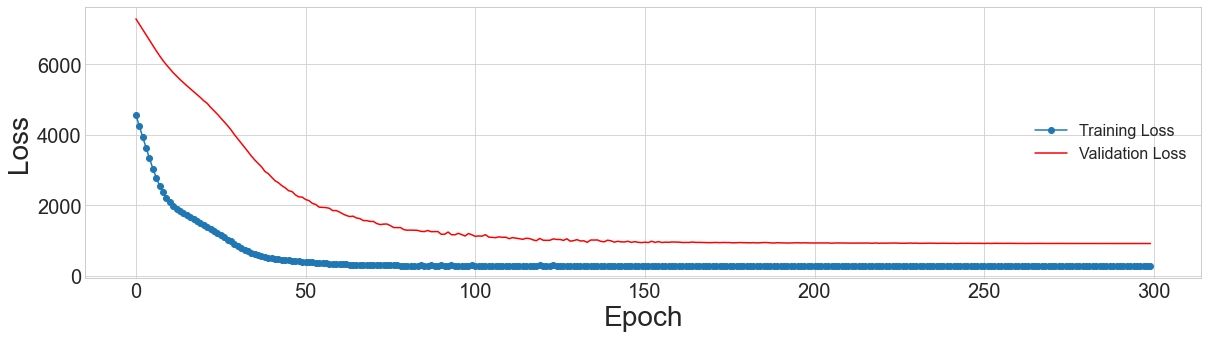

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(metrics_train["MAE"], '-o', label="Training Loss")  
ax.plot(metrics_train["MAE_val"], '-r', label="Validation Loss")
ax.legend(loc='center right', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("Epoch", fontsize=28)
ax.set_ylabel("Loss", fontsize=28)

Test eveluation.

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


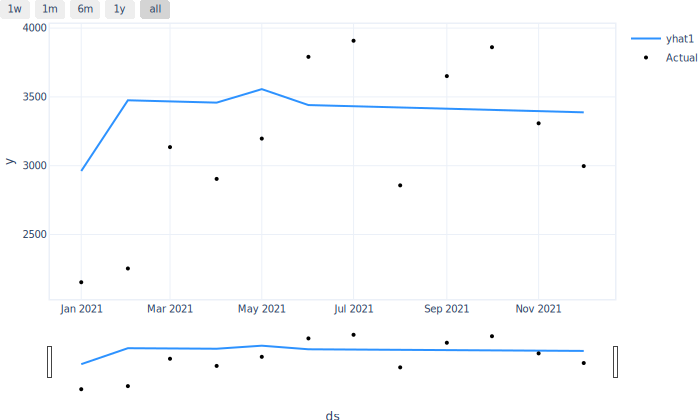

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.07848355919122696
         MAE_val             486.7365417480469
        RMSE_val             561.8782958984375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,486.736542,561.878296,0.078484,0.0


In [15]:
forecast = model.predict(data_test)
model.plot(forecast)

metrics_test = model.test(data_test)
metrics_test

Predict into future.

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.937% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Retur

            ds       y
0   2000-01-01  3448.0
1   2000-02-01  3181.0
2   2000-03-01  3783.0
3   2000-04-01  3317.0
4   2000-05-01  4123.0
..         ...     ...
271 2022-08-01     NaN
272 2022-09-01     NaN
273 2022-10-01     NaN
274 2022-11-01     NaN
275 2022-12-01     NaN

[276 rows x 2 columns]
            ds       y        yhat1        trend  season_yearly  \
0   2000-01-01  3448.0  3154.171875  3595.014160   -1554.518066   
1   2000-02-01  3181.0  3115.745117  3585.949707    -470.204834   
2   2000-03-01  3783.0  3508.707520  3577.469971     -68.762360   
3   2000-04-01  3317.0  3583.177734  3568.405762      14.772249   
4   2000-05-01  4123.0  3665.706299  3559.633545    1323.539673   
..         ...     ...          ...          ...            ...   
271 2022-08-01     NaN  2861.714111  3277.804932    -416.090820   
272 2022-09-01     NaN  3519.894043  3268.911377     250.982635   
273 2022-10-01     NaN  3700.395020  3260.304932     440.089996   
274 2022-11-01     NaN  3318.2

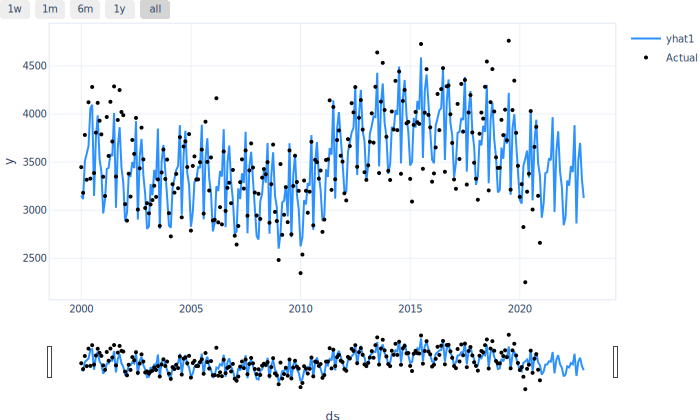

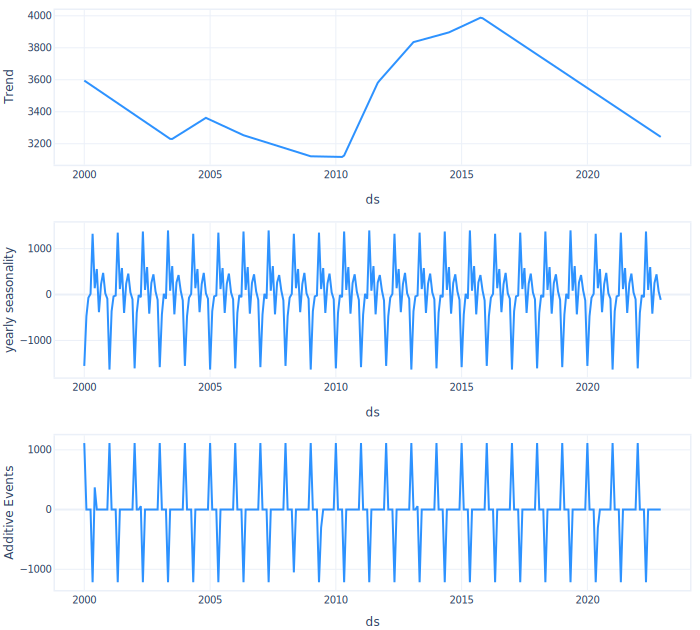

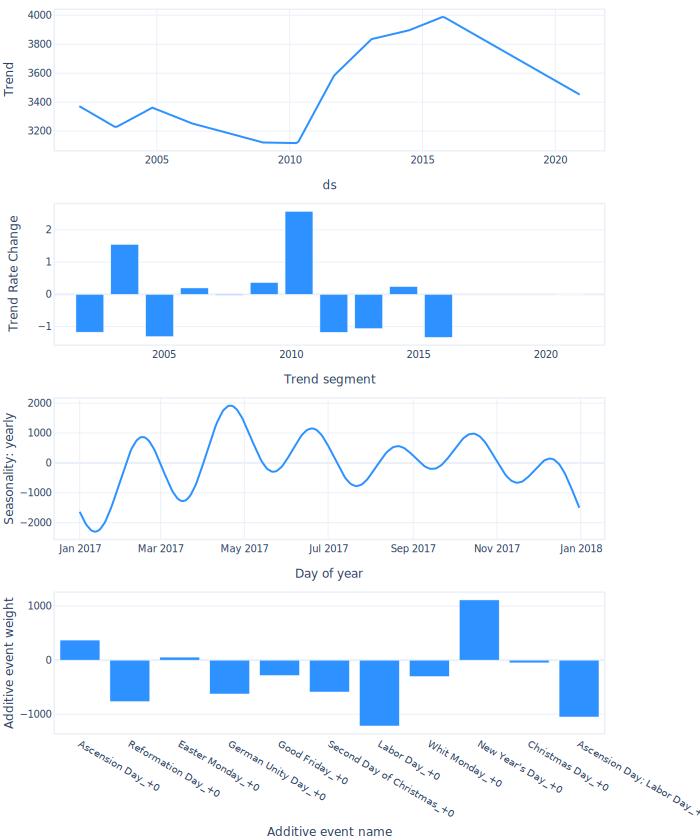

In [11]:
future = model.make_future_dataframe(data_train_val, periods=24, n_historic_predictions=len(data_train_val))
future.sort_values(by='ds', inplace=True, ascending=True)
future.reset_index(drop=True, inplace=True)
print(future)
forecast = model.predict(future)
print(forecast)

fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)
fig_model = model.plot_parameters()

Hyperparameter tuning using grid search.

In [ ]:
model = NeuralProphet(yearly_seasonality='auto', seasonality_mode='additive')
data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.1)
print("Dataset size:", len(data))
print("Train dataset size:", len(data_train))
print("Validation dataset size:", len(data_val))

param_grid = {  
    'learning_rate': [0.001, 0.008, 0.01, 0.1],
    'normalize': ['minmax', 'soft', 'standardize'],
    'epochs': [300],
    'batch_size': [3, 6, 12]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

maes_train = []; rmses_train = []; maes_val = []; rmses_val = []

for params in all_params:
    m = NeuralProphet(**params, yearly_seasonality='auto', seasonality_mode='additive') 
    m = m.add_country_holidays(country_name='DE')
    m.set_plotting_backend('plotly-static')
    metrics_train = m.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
    maes_train.append(metrics_train['MAE'].values[-1])
    rmses_train.append(metrics_train['RMSE'].values[-1])
    maes_val.append(metrics_train['MAE_val'].values[-1])
    rmses_val.append(metrics_train['RMSE_val'].values[-1])
    print(params)
    print('training MAE:' + str(metrics_train['MAE'].values[-1]))
    print('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
    print('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
    print('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
    print('---------------------------------')
    
tuning_results = pd.DataFrame(all_params)
tuning_results['MAE_train'] = maes_train
tuning_results['RMSE_train'] = rmses_train
tuning_results['MAE_val'] = maes_val
tuning_results['RMSE_val'] = rmses_val
tuning_results.sort_values(by='MAE_train', ascending=True, inplace=True)
tuning_results.reset_index(drop=True, inplace=True)
print(tuning_results)

best_params = all_params[np.argmin(maes_train)]
print(best_params)

Save model.

In [62]:
with open('./model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('./model.pkl', 'rb') as f:
    model = pickle.load(f)
    model.restore_trainer()

WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



In [38]:
save(model, "./model.np")

In [8]:
model = load("./model.np")

WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



In [9]:
future = model.make_future_dataframe(data, periods=12)
forecast = model.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.955% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 0it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,events_additive,event_Ascension Day,event_Ascension Day; Labor Day,event_Christmas Day,event_Easter Monday,event_German Unity Day,event_Good Friday,event_Labor Day,event_New Year's Day,event_Reformation Day,event_Second Day of Christmas,event_Whit Monday
0,2022-01-01,None,26.943470,36.103035,-28.444145,19.284582,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,19.284582,0.0,0.0,0.0
1,2022-02-01,None,27.589596,36.216389,-8.626792,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,2022-03-01,None,30.974096,36.318771,-5.344676,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,2022-04-01,None,34.519810,36.432129,-1.912321,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,2022-05-01,None,42.805275,36.541828,2.120008,4.143439,0.0,0.0,0.0,0.0,0.0,0.0,4.143439,0.000000,0.0,0.0,0.0


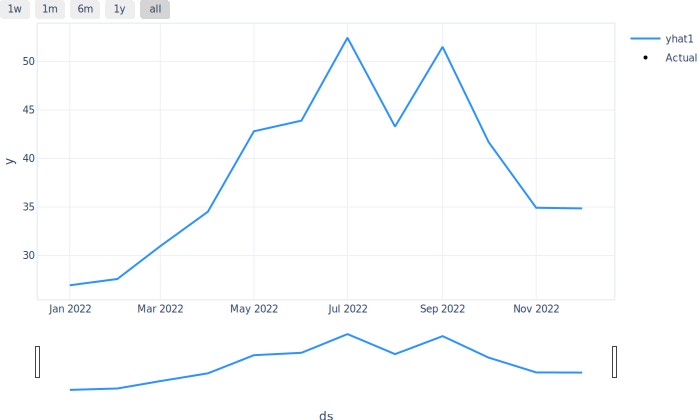

In [13]:
model.plot(forecast, plotting_backend='plotly-static')

Automated pipeline for all steps above.

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3958165/2665213414.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name.sort_values(by='MONAT', inplace=True, ascending=True)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3958165/2665213414.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name.sort_values(by='MONAT', inplace=True, ascending=True)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3958165/2665213414.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

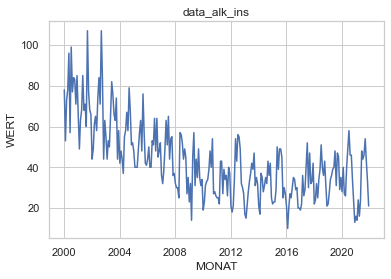

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.603]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


(252, 2)
(12, 2)
Dataset size: 264
Train dataset size: 215
Validation dataset size: 37


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")

Missing logger folder: /u/halle/zhouni/home_at/AccidPre/lightning_logs
INFO - (NP.df_utils._infer

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.014441221952438354
         MAE_val             7.726958751678467
        RMSE_val             9.029202461242676
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:5.852184772491455
training RMSE:6.942885398864746
validation MAE:8.019110679626465
validation RMSE:10.028839111328125
test MAE:7.726958751678467
test RMSE:9.029202461242676
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.018332965672016144
         MAE_val             8.517343521118164
        RMSE_val            10.173344612121582
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:5.735413551330566
training RMSE:7.207051753997803
validation MAE:8.947154998779297
validation RMSE:10.96882152557373
test MAE:8.517343521118164
test RMSE:10.173344612121582
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.051087189465761185
         MAE_val              14.587646484375
        RMSE_val             16.98257064819336
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:6.14850378036499
training RMSE:7.717883586883545
validation MAE:13.858027458190918
validation RMSE:15.664843559265137
test MAE:14.587646484375
test RMSE:16.98257064819336
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.030214881524443626
         MAE_val             8.05063247680664
        RMSE_val             9.411595344543457
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:7.0709052085876465
training RMSE:8.53048324584961
validation MAE:7.579717636108398
validation RMSE:9.265853881835938
test MAE:8.05063247680664
test RMSE:9.411595344543457
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.14025019109249115
         MAE_val             18.90618324279785
        RMSE_val            20.842391967773438
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:8.970987319946289
training RMSE:11.402397155761719
validation MAE:17.033100128173828
validation RMSE:18.954267501831055
test MAE:18.90618324279785
test RMSE:20.842391967773438
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06496873497962952
         MAE_val            11.633769035339355
        RMSE_val            13.801682472229004
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:11.528802871704102
training RMSE:16.164278030395508
validation MAE:11.187783241271973
validation RMSE:13.902491569519043
test MAE:11.633769035339355
test RMSE:13.801682472229004
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.40833762288093567
         MAE_val             10.18031120300293
        RMSE_val            12.201361656188965
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:7.116995811462402
training RMSE:8.494543075561523
validation MAE:10.7600679397583
validation RMSE:12.748016357421875
test MAE:10.18031120300293
test RMSE:12.201361656188965
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.42630457878112793
         MAE_val            10.551884651184082
        RMSE_val            12.678662300109863
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:8.00362491607666
training RMSE:10.688129425048828
validation MAE:10.735831260681152
validation RMSE:12.550917625427246
test MAE:10.551884651184082
test RMSE:12.678662300109863
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.8018743395805359
         MAE_val            17.703651428222656
        RMSE_val            19.714557647705078
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:6.76521110534668
training RMSE:8.594230651855469
validation MAE:16.7712459564209
validation RMSE:18.725276947021484
test MAE:17.703651428222656
test RMSE:19.714557647705078
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01918463222682476
         MAE_val             8.681715965270996
        RMSE_val            10.406966209411621
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:5.5774054527282715
training RMSE:6.757201671600342
validation MAE:9.107385635375977
validation RMSE:11.129772186279297
test MAE:8.681715965270996
test RMSE:10.406966209411621
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.019229743629693985
         MAE_val             8.706883430480957
        RMSE_val            10.419194221496582
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:5.600353240966797
training RMSE:7.131247043609619
validation MAE:9.064667701721191
validation RMSE:11.1295804977417
test MAE:8.706883430480957
test RMSE:10.419194221496582
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.015195447951555252
         MAE_val             7.961082458496094
        RMSE_val             9.26198673248291
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:6.028897285461426
training RMSE:7.764660835266113
validation MAE:8.206249237060547
validation RMSE:10.124532699584961
test MAE:7.961082458496094
test RMSE:9.26198673248291
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.03672805055975914
         MAE_val             8.718605041503906
        RMSE_val            10.376522064208984
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:5.586643218994141
training RMSE:6.602153301239014
validation MAE:9.004196166992188
validation RMSE:11.040532112121582
test MAE:8.718605041503906
test RMSE:10.376522064208984
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.035681989043951035
         MAE_val             8.570040702819824
        RMSE_val            10.227685928344727
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:5.676413536071777
training RMSE:6.892852783203125
validation MAE:8.949164390563965
validation RMSE:10.948799133300781
test MAE:8.570040702819824
test RMSE:10.227685928344727
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.035141054540872574
         MAE_val              8.4341402053833
        RMSE_val            10.149864196777344
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:5.710708141326904
training RMSE:7.414498805999756
validation MAE:8.899626731872559
validation RMSE:10.901042938232422
test MAE:8.4341402053833
test RMSE:10.149864196777344
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.3164616525173187
         MAE_val             8.240232467651367
        RMSE_val             9.955728530883789
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:5.638469219207764
training RMSE:6.658015727996826
validation MAE:8.957701683044434
validation RMSE:10.89864444732666
test MAE:8.240232467651367
test RMSE:9.955728530883789
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.3104959726333618
         MAE_val             8.14456558227539
        RMSE_val             9.786067008972168
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:5.62245512008667
training RMSE:7.273599624633789
validation MAE:8.833673477172852
validation RMSE:10.762454986572266
test MAE:8.14456558227539
test RMSE:9.786067008972168
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.29536691308021545
         MAE_val            7.9338154792785645
        RMSE_val             9.417010307312012
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:5.828710079193115
training RMSE:7.694857120513916
validation MAE:8.601537704467773
validation RMSE:10.498950004577637
test MAE:7.9338154792785645
test RMSE:9.417010307312012
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.019106972962617874
         MAE_val             8.72698974609375
        RMSE_val            10.385881423950195
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:5.59759521484375
training RMSE:6.633216381072998
validation MAE:9.060303688049316
validation RMSE:11.050129890441895
test MAE:8.72698974609375
test RMSE:10.385881423950195
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.019225962460041046
         MAE_val             8.737815856933594
        RMSE_val            10.418169021606445
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:5.632989406585693
training RMSE:7.0735321044921875
validation MAE:9.112447738647461
validation RMSE:11.111550331115723
test MAE:8.737815856933594
test RMSE:10.418169021606445
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.018786095082759857
         MAE_val             8.650790214538574
        RMSE_val             10.29830265045166
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:5.58049201965332
training RMSE:7.252449989318848
validation MAE:9.039653778076172
validation RMSE:11.029109001159668
test MAE:8.650790214538574
test RMSE:10.29830265045166
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.03653164580464363
         MAE_val             8.685734748840332
        RMSE_val            10.348739624023438
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:5.601706027984619
training RMSE:6.576550006866455
validation MAE:8.992477416992188
validation RMSE:10.9896821975708
test MAE:8.685734748840332
test RMSE:10.348739624023438
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.03683866187930107
         MAE_val             8.683024406433105
        RMSE_val            10.392133712768555
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:5.583652973175049
training RMSE:7.088703632354736
validation MAE:9.034493446350098
validation RMSE:11.039337158203125
test MAE:8.683024406433105
test RMSE:10.392133712768555
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0356154628098011
         MAE_val             8.539278984069824
        RMSE_val            10.218145370483398
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:5.633847713470459
training RMSE:7.151020526885986
validation MAE:8.928603172302246
validation RMSE:10.951285362243652
test MAE:8.539278984069824
test RMSE:10.218145370483398
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.3170941472053528
         MAE_val             8.26700210571289
        RMSE_val             9.966781616210938
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:5.533450126647949
training RMSE:6.511106491088867
validation MAE:8.937625885009766
validation RMSE:10.879744529724121
test MAE:8.26700210571289
test RMSE:9.966781616210938
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.31250470876693726
         MAE_val             8.173369407653809
        RMSE_val             9.843218803405762
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:5.564419746398926
training RMSE:7.144262790679932
validation MAE:8.8449125289917
validation RMSE:10.77489948272705
test MAE:8.173369407653809
test RMSE:9.843218803405762
---------------------------------


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonalit

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.30414021015167236
         MAE_val             8.024657249450684
        RMSE_val             9.637568473815918
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:5.76482629776001
training RMSE:7.478704452514648
validation MAE:8.767019271850586
validation RMSE:10.670673370361328
test MAE:8.024657249450684
test RMSE:9.637568473815918
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01952858828008175
         MAE_val             8.76327133178711
        RMSE_val            10.499842643737793
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:5.6580681800842285
training RMSE:6.840343475341797
validation MAE:9.291096687316895
validation RMSE:11.227828025817871
test MAE:8.76327133178711
test RMSE:10.499842643737793
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.019680466502904892
         MAE_val             8.779959678649902
        RMSE_val            10.540594100952148
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:5.5603251457214355
training RMSE:7.015692710876465
validation MAE:9.208597183227539
validation RMSE:11.206977844238281
test MAE:8.779959678649902
test RMSE:10.540594100952148
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.018254654482007027
         MAE_val             8.461604118347168
        RMSE_val            10.151594161987305
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:5.589305400848389
training RMSE:7.087046146392822
validation MAE:8.85685920715332
validation RMSE:10.823878288269043
test MAE:8.461604118347168
test RMSE:10.151594161987305
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.036071307957172394
         MAE_val             8.507347106933594
        RMSE_val            10.283329010009766
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:5.622204303741455
training RMSE:6.514416694641113
validation MAE:9.204691886901855
validation RMSE:11.187899589538574
test MAE:8.507347106933594
test RMSE:10.283329010009766
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.036128632724285126
         MAE_val             8.642559051513672
        RMSE_val            10.291497230529785
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:5.5459513664245605
training RMSE:6.864683151245117
validation MAE:8.97510051727295
validation RMSE:10.97301959991455
test MAE:8.642559051513672
test RMSE:10.291497230529785
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.03620155528187752
         MAE_val             8.687326431274414
        RMSE_val            10.301877975463867
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:5.565583229064941
training RMSE:7.119498252868652
validation MAE:8.950772285461426
validation RMSE:10.960162162780762
test MAE:8.687326431274414
test RMSE:10.301877975463867
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            0.316694051027298
         MAE_val             8.27920913696289
        RMSE_val             9.94654369354248
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:5.499023914337158
training RMSE:6.653561592102051
validation MAE:8.851295471191406
validation RMSE:10.79101276397705
test MAE:8.27920913696289
test RMSE:9.94654369354248
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            0.314002126455307
         MAE_val             8.235347747802734
        RMSE_val             9.893062591552734
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:5.498020172119141
training RMSE:7.0961174964904785
validation MAE:8.842316627502441
validation RMSE:10.777844429016113
test MAE:8.235347747802734
test RMSE:9.893062591552734
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.31845393776893616
         MAE_val             8.328585624694824
        RMSE_val             9.996719360351562
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:5.4843926429748535
training RMSE:7.243442058563232
validation MAE:8.917080879211426
validation RMSE:10.85716724395752
test MAE:8.328585624694824
test RMSE:9.996719360351562
---------------------------------
    learning_rate    normalize  epochs  batch_size  MAE_train  RMSE_train  \
0           0.001       minmax

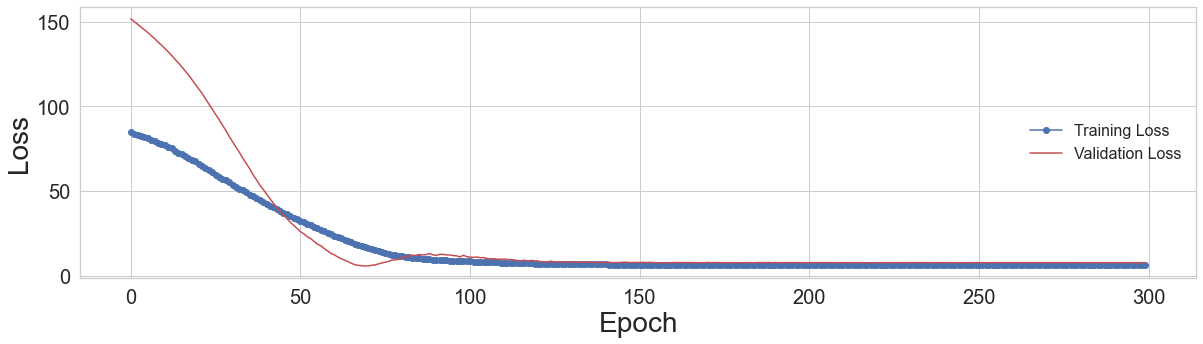

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


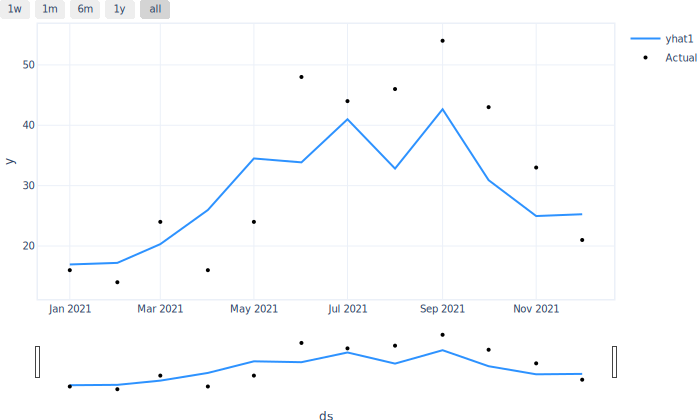

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.014388767071068287
         MAE_val             7.864330291748047
        RMSE_val             9.012788772583008
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MAE_val  RMSE_val  Loss_test  RegLoss_test
0  7.86433  9.012789   0.014389           0.0


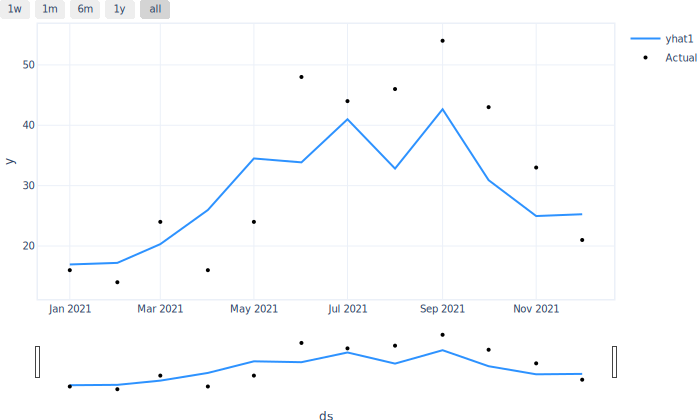

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.603]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.014388767071068287
         MAE_val             7.864330291748047
        RMSE_val             9.012788772583008
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MAE_val  RMSE_val  Loss_test  RegLoss_test
0  7.86433  9.012789   0.014389           0.0
            ds     y
0   2000-01-01  78.0
1   2000-02-01  53.0
2   2000-03-01  73.0
3   2000-04-01  78.0
4   2000-05-01  96.0
..         ...   ...
271 2022-08-01   NaN
272 2022-09-01   NaN
273 2022-10-01   NaN
274 2022-11-01   NaN
275 2022-12-01   NaN

[276 rows x 2 columns]
            ds     y      yhat1      trend 

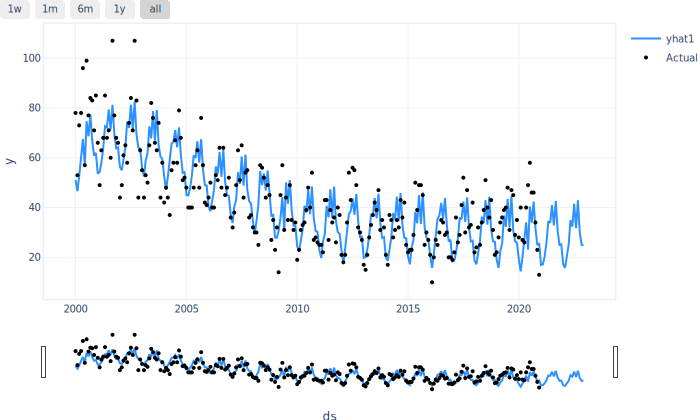

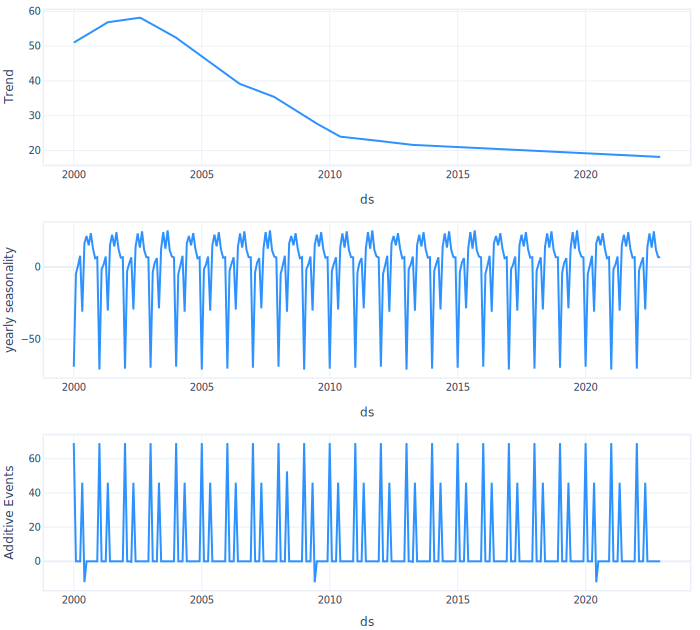

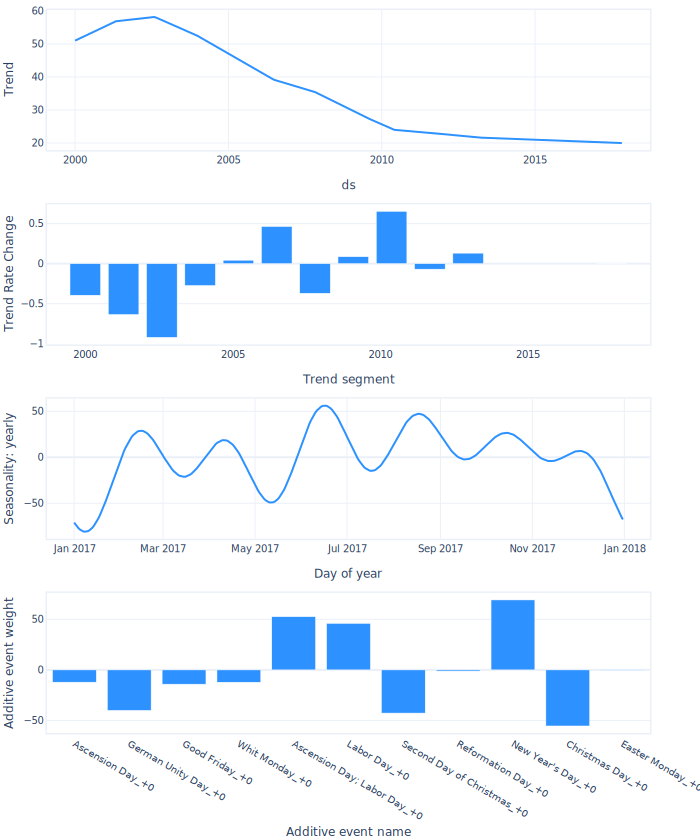

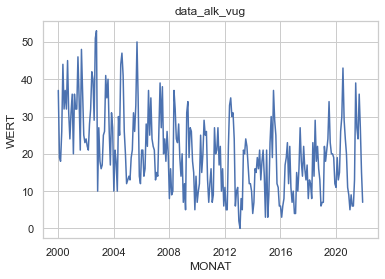

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.603]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralP

(252, 2)
(12, 2)
Dataset size: 264
Train dataset size: 215
Validation dataset size: 37


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.047931596636772156
         MAE_val             6.965061664581299
        RMSE_val             9.017521858215332
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:4.811559677124023
training RMSE:5.643266677856445
validation MAE:5.893472671508789
validation RMSE:7.587188243865967
test MAE:6.965061664581299
test RMSE:9.017521858215332
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.07270640134811401
         MAE_val             9.210871696472168
        RMSE_val            11.254097938537598
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:5.488013744354248
training RMSE:6.889210224151611
validation MAE:7.83894157409668
validation RMSE:9.502869606018066
test MAE:9.210871696472168
test RMSE:11.254097938537598
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06167963147163391
         MAE_val             8.188655853271484
        RMSE_val             10.29606819152832
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:5.040952205657959
training RMSE:6.3737263679504395
validation MAE:7.034544467926025
validation RMSE:8.727116584777832
test MAE:8.188655853271484
test RMSE:10.29606819152832
---------------------------------


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonalit

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08187559247016907
         MAE_val             7.233455181121826
        RMSE_val             9.373579025268555
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:4.86882209777832
training RMSE:5.637538433074951
validation MAE:6.095201015472412
validation RMSE:7.787106990814209
test MAE:7.233455181121826
test RMSE:9.373579025268555
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.11819910258054733
         MAE_val             9.518125534057617
        RMSE_val            11.668606758117676
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:5.587368488311768
training RMSE:6.835671901702881
validation MAE:7.430715084075928
validation RMSE:8.960958480834961
test MAE:9.518125534057617
test RMSE:11.668606758117676
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.18593381345272064
         MAE_val             12.9933443069458
        RMSE_val            14.498761177062988
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:11.479890823364258
training RMSE:15.021201133728027
validation MAE:9.41409683227539
validation RMSE:10.664268493652344
test MAE:12.9933443069458
test RMSE:14.498761177062988
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.6890937685966492
         MAE_val             9.171053886413574
        RMSE_val             11.4037446975708
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:4.745192527770996
training RMSE:5.6981377601623535
validation MAE:8.026130676269531
validation RMSE:9.595974922180176
test MAE:9.171053886413574
test RMSE:11.4037446975708
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.7525718808174133
         MAE_val             9.867033958435059
        RMSE_val            12.235992431640625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:5.126230716705322
training RMSE:6.579814910888672
validation MAE:8.342884063720703
validation RMSE:9.849282264709473
test MAE:9.867033958435059
test RMSE:12.235992431640625
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.6390256881713867
         MAE_val             8.583027839660645
        RMSE_val            10.904141426086426
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:5.34424352645874
training RMSE:7.148594379425049
validation MAE:7.09425163269043
validation RMSE:8.62766170501709
test MAE:8.583027839660645
test RMSE:10.904141426086426
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.05518404021859169
         MAE_val             7.603963851928711
        RMSE_val             9.707983016967773
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:4.795175552368164
training RMSE:5.514811992645264
validation MAE:6.384477138519287
validation RMSE:8.053163528442383
test MAE:7.603963851928711
test RMSE:9.707983016967773
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0541873574256897
         MAE_val             7.504432678222656
        RMSE_val             9.614889144897461
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:4.821346282958984
training RMSE:5.832137584686279
validation MAE:6.330854892730713
validation RMSE:7.990776538848877
test MAE:7.504432678222656
test RMSE:9.614889144897461
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.05614864453673363
         MAE_val             7.710184097290039
        RMSE_val             9.790596008300781
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:4.791318416595459
training RMSE:5.9802021980285645
validation MAE:6.531585693359375
validation RMSE:8.16462516784668
test MAE:7.710184097290039
test RMSE:9.790596008300781
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08776718378067017
         MAE_val             7.653852939605713
        RMSE_val             9.757373809814453
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:4.807626724243164
training RMSE:5.627641677856445
validation MAE:6.44430685043335
validation RMSE:8.081353187561035
test MAE:7.653852939605713
test RMSE:9.757373809814453
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08714842796325684
         MAE_val             7.614053726196289
        RMSE_val             9.72514533996582
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:4.827258586883545
training RMSE:5.883367538452148
validation MAE:6.401433944702148
validation RMSE:8.055646896362305
test MAE:7.614053726196289
test RMSE:9.72514533996582
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08993315696716309
         MAE_val             7.813474178314209
        RMSE_val             9.902339935302734
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:4.83673620223999
training RMSE:6.027209758758545
validation MAE:6.533779144287109
validation RMSE:8.200087547302246
test MAE:7.813474178314209
test RMSE:9.902339935302734
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5955957770347595
         MAE_val             8.03761100769043
        RMSE_val            10.188521385192871
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:4.65807580947876
training RMSE:5.6523213386535645
validation MAE:7.080467224121094
validation RMSE:8.643136978149414
test MAE:8.03761100769043
test RMSE:10.188521385192871
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5863519310951233
         MAE_val            7.9155426025390625
        RMSE_val            10.085142135620117
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:4.681446552276611
training RMSE:5.906839847564697
validation MAE:7.003467559814453
validation RMSE:8.565974235534668
test MAE:7.9155426025390625
test RMSE:10.085142135620117
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5948800444602966
         MAE_val             8.028203964233398
        RMSE_val            10.209611892700195
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:4.689215660095215
training RMSE:6.133514404296875
validation MAE:7.097218990325928
validation RMSE:8.651275634765625
test MAE:8.028203964233398
test RMSE:10.209611892700195
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.055654093623161316
         MAE_val             7.637601375579834
        RMSE_val             9.748108863830566
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:4.777088642120361
training RMSE:5.545148849487305
validation MAE:6.393775463104248
validation RMSE:8.037691116333008
test MAE:7.637601375579834
test RMSE:9.748108863830566
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.055447984486818314
         MAE_val             7.629110336303711
        RMSE_val             9.729591369628906
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:4.798313140869141
training RMSE:5.894216060638428
validation MAE:6.456396102905273
validation RMSE:8.094644546508789
test MAE:7.629110336303711
test RMSE:9.729591369628906
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.055366743355989456
         MAE_val              7.6278977394104
        RMSE_val             9.723434448242188
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:4.799754619598389
training RMSE:6.000844478607178
validation MAE:6.455707550048828
validation RMSE:8.101197242736816
test MAE:7.6278977394104
test RMSE:9.723434448242188
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08685479313135147
         MAE_val             7.594675064086914
        RMSE_val             9.706716537475586
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:4.799403667449951
training RMSE:5.579802513122559
validation MAE:6.400442600250244
validation RMSE:8.0527982711792
test MAE:7.594675064086914
test RMSE:9.706716537475586
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08811169117689133
         MAE_val             7.67835807800293
        RMSE_val             9.786727905273438
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:4.802043914794922
training RMSE:5.845120906829834
validation MAE:6.440568923950195
validation RMSE:8.09941577911377
test MAE:7.67835807800293
test RMSE:9.786727905273438
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08992382884025574
         MAE_val             7.810668468475342
        RMSE_val             9.906502723693848
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:4.814316272735596
training RMSE:5.9983601570129395
validation MAE:6.54180383682251
validation RMSE:8.197232246398926
test MAE:7.810668468475342
test RMSE:9.906502723693848
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5978265404701233
         MAE_val             8.07754898071289
        RMSE_val            10.226912498474121
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:4.67315149307251
training RMSE:5.662069797515869
validation MAE:7.1283278465271
validation RMSE:8.686219215393066
test MAE:8.07754898071289
test RMSE:10.226912498474121
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5987514853477478
         MAE_val             8.088364601135254
        RMSE_val            10.243383407592773
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:4.656904220581055
training RMSE:5.933449745178223
validation MAE:7.135569095611572
validation RMSE:8.69517993927002
test MAE:8.088364601135254
test RMSE:10.243383407592773
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            0.59514981508255
         MAE_val             8.033551216125488
        RMSE_val             10.21213436126709
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:4.6905622482299805
training RMSE:6.119090557098389
validation MAE:7.0887370109558105
validation RMSE:8.644096374511719
test MAE:8.033551216125488
test RMSE:10.21213436126709
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.057821471244096756
         MAE_val             7.845901012420654
        RMSE_val             9.940882682800293
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:4.834255218505859
training RMSE:5.6986775398254395
validation MAE:6.91109037399292
validation RMSE:8.523581504821777
test MAE:7.845901012420654
test RMSE:9.940882682800293
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.052493926137685776
         MAE_val             7.375687122344971
        RMSE_val             9.452263832092285
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:4.883358001708984
training RMSE:5.912951946258545
validation MAE:6.102043151855469
validation RMSE:7.793032169342041
test MAE:7.375687122344971
test RMSE:9.452263832092285
---------------------------------


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonalit

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.05391979217529297
         MAE_val             7.518909931182861
        RMSE_val             9.59083080291748
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:4.808096885681152
training RMSE:6.028041839599609
validation MAE:6.335261821746826
validation RMSE:7.994237422943115
test MAE:7.518909931182861
test RMSE:9.59083080291748
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08737581968307495
         MAE_val             7.600630283355713
        RMSE_val             9.718214988708496
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:4.812836647033691
training RMSE:5.702539920806885
validation MAE:6.3858489990234375
validation RMSE:8.041102409362793
test MAE:7.600630283355713
test RMSE:9.718214988708496
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08706765621900558
         MAE_val             7.575350284576416
        RMSE_val             9.706624031066895
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:4.821093559265137
training RMSE:5.920931816101074
validation MAE:6.368592739105225
validation RMSE:8.041739463806152
test MAE:7.575350284576416
test RMSE:9.706624031066895
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08764500170946121
         MAE_val             7.659193515777588
        RMSE_val             9.750396728515625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:4.823222637176514
training RMSE:6.064303874969482
validation MAE:6.423136234283447
validation RMSE:8.064410209655762
test MAE:7.659193515777588
test RMSE:9.750396728515625
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5956009030342102
         MAE_val             8.052046775817871
        RMSE_val            10.186197280883789
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:4.661154270172119
training RMSE:5.616060256958008
validation MAE:7.150184631347656
validation RMSE:8.689962387084961
test MAE:8.052046775817871
test RMSE:10.186197280883789
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5932459831237793
         MAE_val             8.026155471801758
        RMSE_val            10.159302711486816
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:4.623150825500488
training RMSE:5.914731502532959
validation MAE:7.1099371910095215
validation RMSE:8.655762672424316
test MAE:8.026155471801758
test RMSE:10.159302711486816
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5935737490653992
         MAE_val             8.02497673034668
        RMSE_val            10.157938957214355
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:4.643186092376709
training RMSE:6.16041374206543
validation MAE:7.117659091949463
validation RMSE:8.669136047363281
test MAE:8.02497673034668
test RMSE:10.157938957214355
---------------------------------
    learning_rate    normalize  epochs  batch_size  MAE_train  RMSE_train  \
0           0.001       minmax    

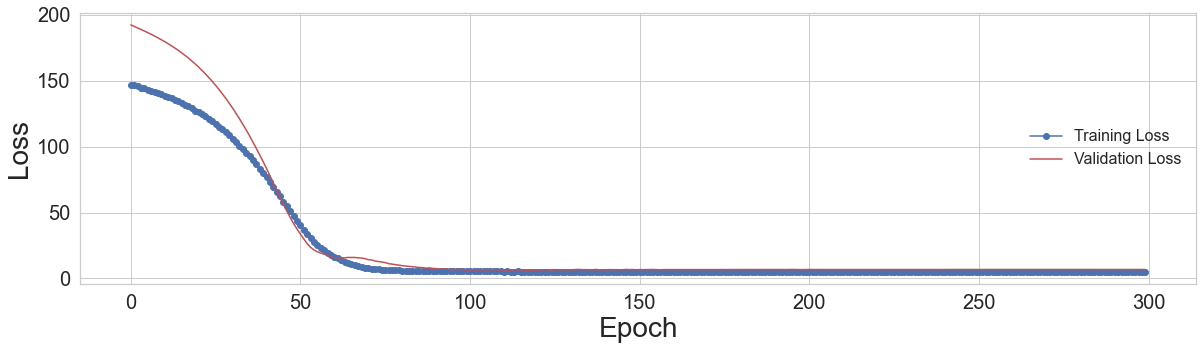

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


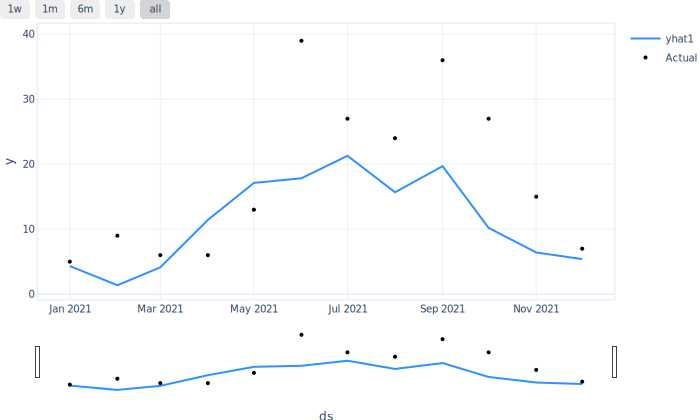

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06200423464179039
         MAE_val             8.184864044189453
        RMSE_val             10.33876895904541
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    MAE_val   RMSE_val  Loss_test  RegLoss_test
0  8.184864  10.338769   0.062004           0.0


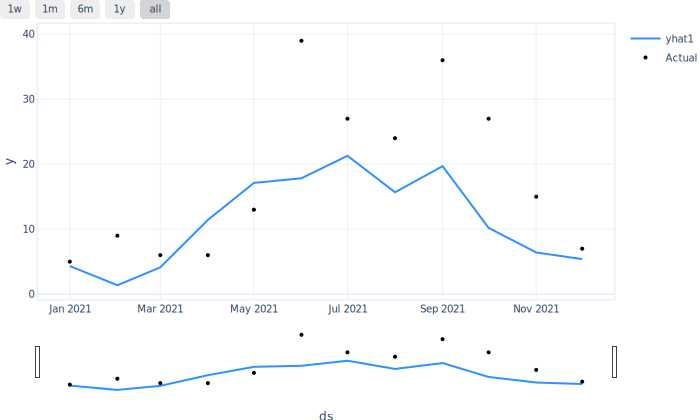

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.603]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06200423464179039
         MAE_val             8.184864044189453
        RMSE_val             10.33876895904541
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    MAE_val   RMSE_val  Loss_test  RegLoss_test
0  8.184864  10.338769   0.062004           0.0
            ds     y
0   2000-01-01  37.0
1   2000-02-01  19.0
2   2000-03-01  18.0
3   2000-04-01  26.0
4   2000-05-01  44.0
..         ...   ...
271 2022-08-01   NaN
272 2022-09-01   NaN
273 2022-10-01   NaN
274 2022-11-01   NaN
275 2022-12-01   NaN

[276 rows x 2 columns]
            ds     y      yhat1      tr

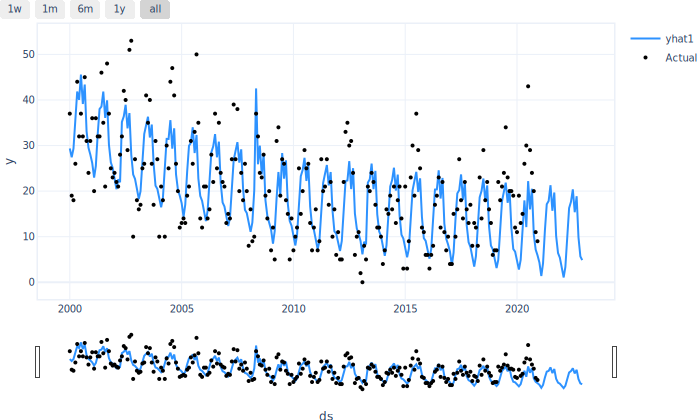

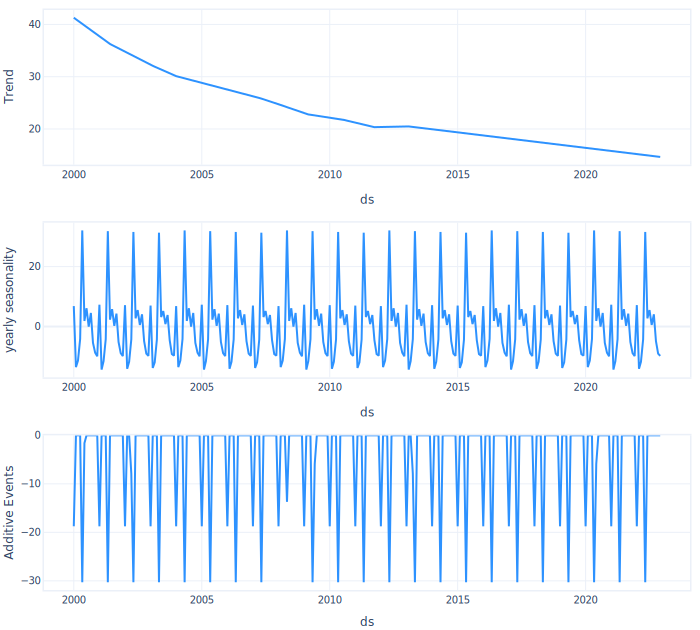

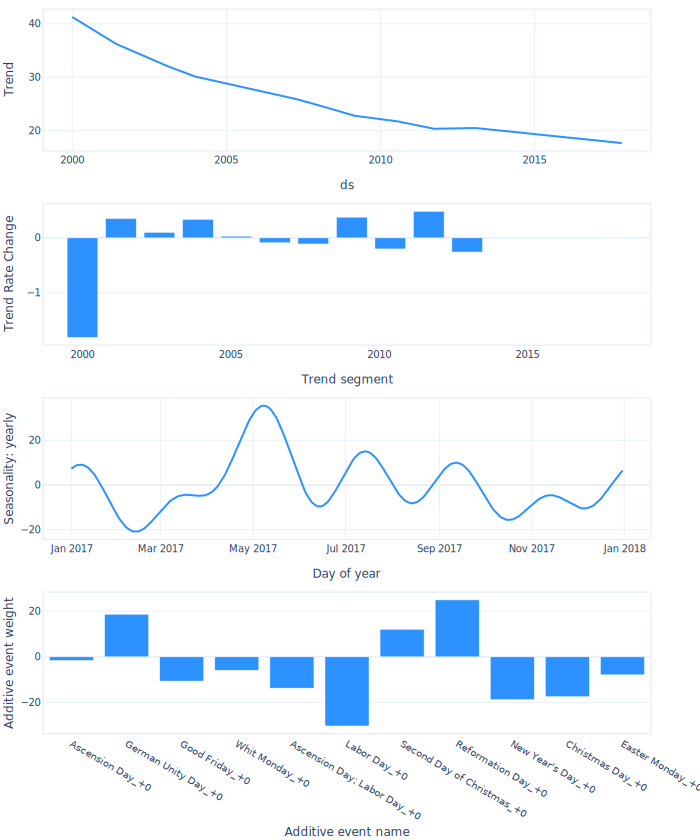

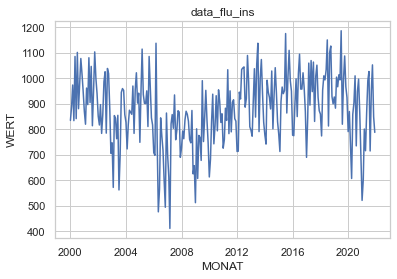

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.603]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralP

(252, 2)
(12, 2)
Dataset size: 264
Train dataset size: 215
Validation dataset size: 37


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09017764776945114
         MAE_val            155.08221435546875
        RMSE_val            180.12098693847656
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:61.51256561279297
training RMSE:74.54732513427734
validation MAE:73.61422729492188
validation RMSE:105.3358154296875
test MAE:155.08221435546875
test RMSE:180.12098693847656
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.048399925231933594
         MAE_val             103.8902359008789
        RMSE_val            130.43728637695312
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:152.34645080566406
training RMSE:200.79054260253906
validation MAE:81.4526596069336
validation RMSE:112.62039947509766
test MAE:103.8902359008789
test RMSE:130.43728637695312
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.03948669135570526
         MAE_val             94.6351318359375
        RMSE_val            117.77898406982422
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:99.73301696777344
training RMSE:137.46542358398438
validation MAE:81.37065887451172
validation RMSE:102.59136199951172
test MAE:94.6351318359375
test RMSE:117.77898406982422
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.11557909101247787
         MAE_val            157.18984985351562
        RMSE_val              181.90869140625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:65.74458312988281
training RMSE:81.9453125
validation MAE:73.14342498779297
validation RMSE:104.8165054321289
test MAE:157.18984985351562
test RMSE:181.90869140625
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.14098979532718658
         MAE_val             180.8605194091797
        RMSE_val             202.6675567626953
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:70.73765563964844
training RMSE:92.20264434814453
validation MAE:79.1966552734375
validation RMSE:112.73273468017578
test MAE:180.8605194091797
test RMSE:202.6675567626953
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.7104466557502747
         MAE_val             577.7899169921875
        RMSE_val             585.0411376953125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:287.9064636230469
training RMSE:383.4187927246094
validation MAE:358.65771484375
validation RMSE:386.5434875488281
test MAE:577.7899169921875
test RMSE:585.0411376953125
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           1.0525047779083252
         MAE_val             160.4840087890625
        RMSE_val             184.4773406982422
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:67.14713287353516
training RMSE:82.15911865234375
validation MAE:76.49925994873047
validation RMSE:106.92300415039062
test MAE:160.4840087890625
test RMSE:184.4773406982422
---------------------------------


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonalit

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           1.0583220720291138
         MAE_val             161.4285430908203
        RMSE_val            185.09547424316406
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:69.25601959228516
training RMSE:92.97789001464844
validation MAE:76.35540771484375
validation RMSE:106.7990493774414
test MAE:161.4285430908203
test RMSE:185.09547424316406
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.9127941727638245
         MAE_val             142.3020782470703
        RMSE_val             166.3617401123047
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:74.09163665771484
training RMSE:101.7005386352539
validation MAE:73.19386291503906
validation RMSE:100.7599868774414
test MAE:142.3020782470703
test RMSE:166.3617401123047
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0716087818145752
         MAE_val            132.12660217285156
        RMSE_val            159.48736572265625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:58.58509063720703
training RMSE:72.07667541503906
validation MAE:71.2334976196289
validation RMSE:98.8456039428711
test MAE:132.12660217285156
test RMSE:159.48736572265625
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0697549507021904
         MAE_val            129.43463134765625
        RMSE_val             157.3717498779297
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:62.21797180175781
training RMSE:82.06507110595703
validation MAE:70.36106872558594
validation RMSE:97.7240219116211
test MAE:129.43463134765625
test RMSE:157.3717498779297
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.07149612158536911
         MAE_val            132.93174743652344
        RMSE_val             159.3030548095703
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:60.54692459106445
training RMSE:85.63692474365234
validation MAE:72.11824798583984
validation RMSE:100.15897369384766
test MAE:132.93174743652344
test RMSE:159.3030548095703
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08837956935167313
         MAE_val            130.33714294433594
        RMSE_val             157.2742919921875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:58.46540832519531
training RMSE:72.02175903320312
validation MAE:71.21912384033203
validation RMSE:98.81170654296875
test MAE:130.33714294433594
test RMSE:157.2742919921875
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0896134302020073
         MAE_val             131.4690704345703
        RMSE_val            158.45449829101562
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:58.976531982421875
training RMSE:77.98484802246094
validation MAE:71.2513198852539
validation RMSE:99.05074310302734
test MAE:131.4690704345703
test RMSE:158.45449829101562
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0966331735253334
         MAE_val             138.2567138671875
        RMSE_val            165.03311157226562
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:60.47176742553711
training RMSE:86.30754852294922
validation MAE:71.74917602539062
validation RMSE:100.47683715820312
test MAE:138.2567138671875
test RMSE:165.03311157226562
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.8421915173530579
         MAE_val             132.4836883544922
        RMSE_val            158.68768310546875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:61.91616439819336
training RMSE:75.76714324951172
validation MAE:74.02403259277344
validation RMSE:100.29928588867188
test MAE:132.4836883544922
test RMSE:158.68768310546875
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.9214329123497009
         MAE_val            142.90521240234375
        RMSE_val            168.73182678222656
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:61.62363815307617
training RMSE:85.58922576904297
validation MAE:74.17431640625
validation RMSE:102.2057876586914
test MAE:142.90521240234375
test RMSE:168.73182678222656
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           1.0717867612838745
         MAE_val             163.6473388671875
        RMSE_val            187.51307678222656
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:63.152828216552734
training RMSE:89.12652587890625
validation MAE:76.00819396972656
validation RMSE:107.2554702758789
test MAE:163.6473388671875
test RMSE:187.51307678222656
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.07046479731798172
         MAE_val             130.8340606689453
        RMSE_val            158.13319396972656
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:58.31279754638672
training RMSE:72.66575622558594
validation MAE:71.2728271484375
validation RMSE:98.89990234375
test MAE:130.8340606689453
test RMSE:158.13319396972656
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.07072994858026505
         MAE_val             131.2407989501953
        RMSE_val            158.42454528808594
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:58.52009963989258
training RMSE:77.93930053710938
validation MAE:71.54154968261719
validation RMSE:99.23497772216797
test MAE:131.2407989501953
test RMSE:158.42454528808594
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06594841182231903
         MAE_val            125.08843994140625
        RMSE_val             152.7459716796875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:60.49727249145508
training RMSE:85.27776336669922
validation MAE:71.35993957519531
validation RMSE:98.03092193603516
test MAE:125.08843994140625
test RMSE:152.7459716796875
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08980593830347061
         MAE_val            131.77223205566406
        RMSE_val            158.60751342773438
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:58.04255676269531
training RMSE:71.61851501464844
validation MAE:71.35726165771484
validation RMSE:99.1444320678711
test MAE:131.77223205566406
test RMSE:158.60751342773438
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08864238858222961
         MAE_val            130.73545837402344
        RMSE_val            157.46380615234375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:59.119232177734375
training RMSE:78.23484802246094
validation MAE:71.52971649169922
validation RMSE:99.0617904663086
test MAE:130.73545837402344
test RMSE:157.46380615234375
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08801478147506714
         MAE_val            130.51536560058594
        RMSE_val            156.85140991210938
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:61.88095474243164
training RMSE:87.14970397949219
validation MAE:72.31546783447266
validation RMSE:99.91097259521484
test MAE:130.51536560058594
test RMSE:156.85140991210938
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.8221628069877625
         MAE_val            129.76210021972656
        RMSE_val            156.15762329101562
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:60.244239807128906
training RMSE:74.85743713378906
validation MAE:73.91079711914062
validation RMSE:100.00133514404297
test MAE:129.76210021972656
test RMSE:156.15762329101562
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.8868114352226257
         MAE_val            138.38368225097656
        RMSE_val            164.34324645996094
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:60.92702865600586
training RMSE:82.96634674072266
validation MAE:74.25006103515625
validation RMSE:101.56647491455078
test MAE:138.38368225097656
test RMSE:164.34324645996094
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            1.008261799812317
         MAE_val             154.6622772216797
        RMSE_val            179.56512451171875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:61.85491180419922
training RMSE:88.18965911865234
validation MAE:75.01449584960938
validation RMSE:105.28765869140625
test MAE:154.6622772216797
test RMSE:179.56512451171875
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06882686167955399
         MAE_val              129.0654296875
        RMSE_val            156.48947143554688
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:58.54611587524414
training RMSE:70.21002960205078
validation MAE:70.79991912841797
validation RMSE:98.0397720336914
test MAE:129.0654296875
test RMSE:156.48947143554688
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06895387172698975
         MAE_val             129.0975341796875
        RMSE_val             156.3490447998047
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:57.92451858520508
training RMSE:76.41702270507812
validation MAE:71.57584381103516
validation RMSE:98.82050323486328
test MAE:129.0975341796875
test RMSE:156.3490447998047
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.07017455250024796
         MAE_val             130.4008026123047
        RMSE_val             157.820556640625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:57.850120544433594
training RMSE:79.45640563964844
validation MAE:70.98135375976562
validation RMSE:98.68221282958984
test MAE:130.4008026123047
test RMSE:157.820556640625
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09052558988332748
         MAE_val            132.11692810058594
        RMSE_val             159.3724822998047
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:58.786766052246094
training RMSE:72.17271423339844
validation MAE:70.83162689208984
validation RMSE:98.94470977783203
test MAE:132.11692810058594
test RMSE:159.3724822998047
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09070353955030441
         MAE_val             132.7064971923828
        RMSE_val            159.62815856933594
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:58.36616134643555
training RMSE:76.05065155029297
validation MAE:70.7250747680664
validation RMSE:98.9206771850586
test MAE:132.7064971923828
test RMSE:159.62815856933594
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08552420139312744
         MAE_val            127.04791259765625
        RMSE_val            154.46563720703125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:57.88041687011719
training RMSE:80.25296020507812
validation MAE:71.31023406982422
validation RMSE:98.0822982788086
test MAE:127.04791259765625
test RMSE:154.46563720703125
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.7696056365966797
         MAE_val            122.54676055908203
        RMSE_val             149.7790985107422
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:57.989410400390625
training RMSE:72.0066909790039
validation MAE:73.65033721923828
validation RMSE:99.11229705810547
test MAE:122.54676055908203
test RMSE:149.7790985107422
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.7699421048164368
         MAE_val            122.67132568359375
        RMSE_val            149.74261474609375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:58.19371032714844
training RMSE:77.68779754638672
validation MAE:73.71673583984375
validation RMSE:99.31463623046875
test MAE:122.67132568359375
test RMSE:149.74261474609375
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.7653376460075378
         MAE_val            122.02264404296875
        RMSE_val            149.24285888671875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:58.49514389038086
training RMSE:84.19464874267578
validation MAE:73.72796630859375
validation RMSE:99.17961883544922
test MAE:122.02264404296875
test RMSE:149.24285888671875
---------------------------------
    learning_rate    normalize  epochs  batch_size   MAE_train  RMSE_train  \
0           0.001       minma

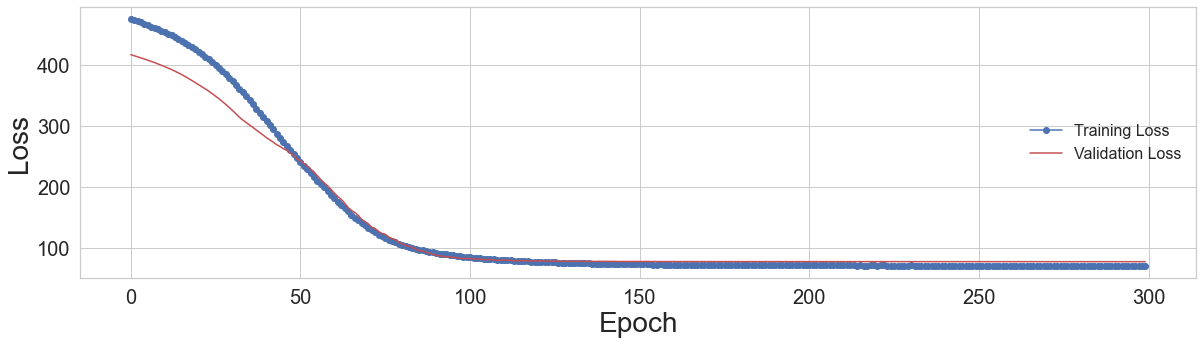

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


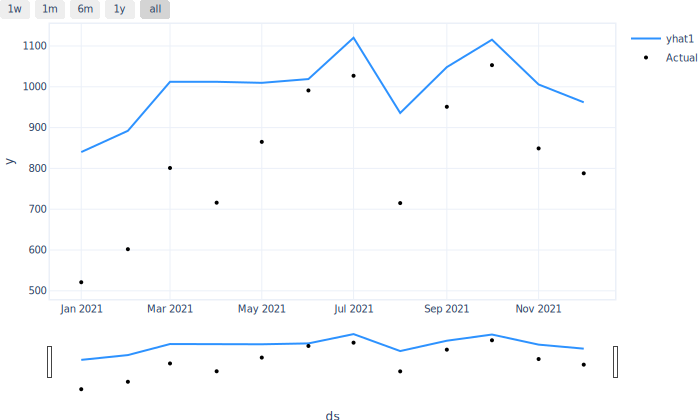

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.10667794942855835
         MAE_val             174.4627227783203
        RMSE_val             196.9879913330078
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      MAE_val    RMSE_val  Loss_test  RegLoss_test
0  174.462723  196.987991   0.106678           0.0


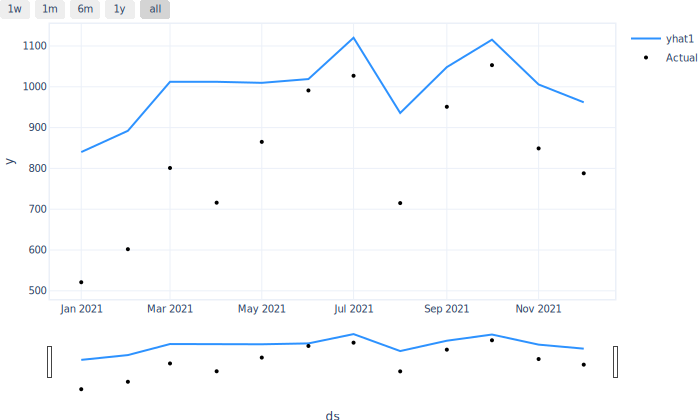

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.603]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Returning 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.10667794942855835
         MAE_val             174.4627227783203
        RMSE_val             196.9879913330078
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      MAE_val    RMSE_val  Loss_test  RegLoss_test
0  174.462723  196.987991   0.106678           0.0
            ds       y
0   2000-01-01   835.0
1   2000-02-01   890.0
2   2000-03-01   974.0
3   2000-04-01   834.0
4   2000-05-01  1086.0
..         ...     ...
271 2022-08-01     NaN
272 2022-09-01     NaN
273 2022-10-01     NaN
274 2022-11-01     NaN
275 2022-12-01     NaN

[276 rows x 2 columns]
         

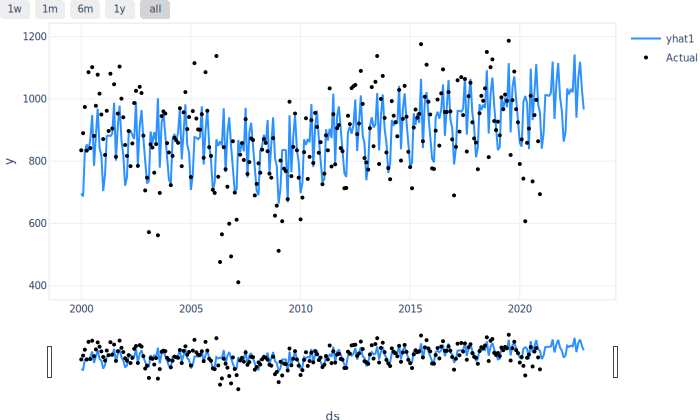

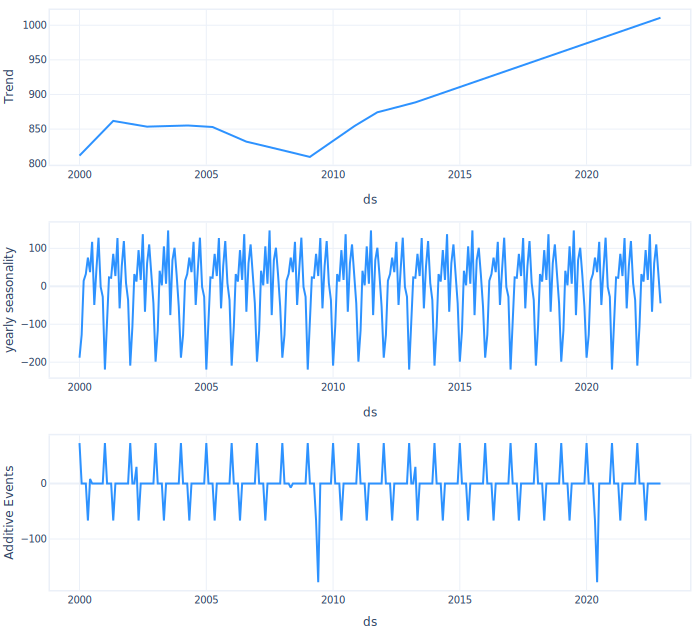

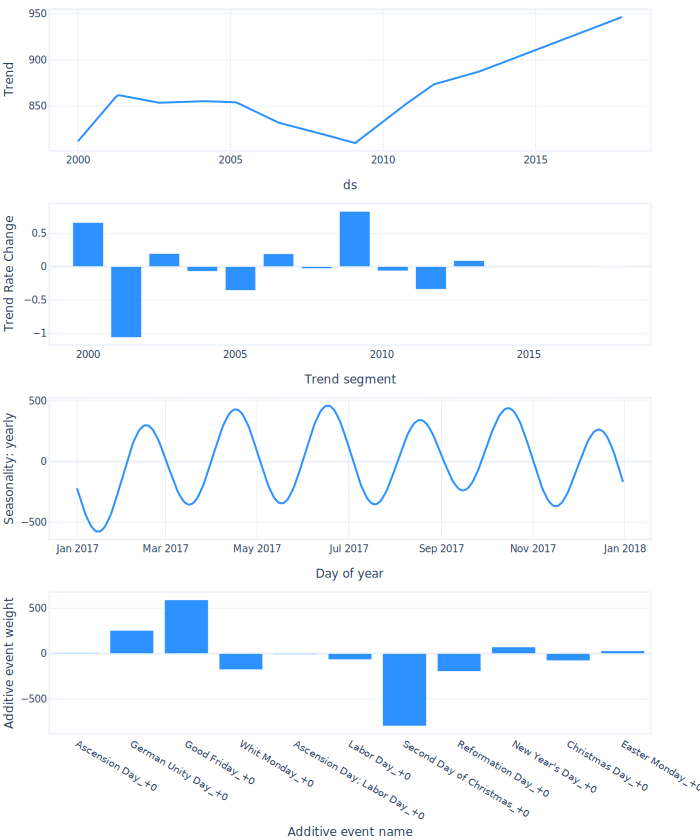

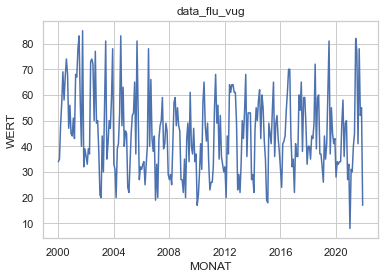

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.603]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralP

(252, 2)
(12, 2)
Dataset size: 264
Train dataset size: 215
Validation dataset size: 37


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0659915879368782
         MAE_val            11.366284370422363
        RMSE_val             13.54641056060791
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:7.465878009796143
training RMSE:8.858466148376465
validation MAE:7.0528645515441895
validation RMSE:8.348366737365723
test MAE:11.366284370422363
test RMSE:13.54641056060791
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06549191474914551
         MAE_val             11.2884521484375
        RMSE_val            13.496813774108887
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:7.1497931480407715
training RMSE:8.819536209106445
validation MAE:7.055135250091553
validation RMSE:8.391883850097656
test MAE:11.2884521484375
test RMSE:13.496813774108887
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.07383137196302414
         MAE_val             12.48034381866455
        RMSE_val            14.365885734558105
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:10.97939682006836
training RMSE:15.051689147949219
validation MAE:7.618211269378662
validation RMSE:8.990805625915527
test MAE:12.48034381866455
test RMSE:14.365885734558105
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09183171391487122
         MAE_val            11.175010681152344
        RMSE_val             13.39980411529541
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:7.225879669189453
training RMSE:8.57075023651123
validation MAE:6.972981929779053
validation RMSE:8.188945770263672
test MAE:11.175010681152344
test RMSE:13.39980411529541
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09429911524057388
         MAE_val             11.62624454498291
        RMSE_val             13.57690715789795
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:7.90028715133667
training RMSE:9.612220764160156
validation MAE:7.267387390136719
validation RMSE:8.418498039245605
test MAE:11.62624454498291
test RMSE:13.57690715789795
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09350568801164627
         MAE_val            11.329560279846191
        RMSE_val            13.547377586364746
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:7.407364845275879
training RMSE:9.533880233764648
validation MAE:7.062943935394287
validation RMSE:8.459121704101562
test MAE:11.329560279846191
test RMSE:13.547377586364746
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5885565876960754
         MAE_val            11.141051292419434
        RMSE_val             13.55156421661377
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:7.585510730743408
training RMSE:8.902828216552734
validation MAE:6.727758884429932
validation RMSE:8.006102561950684
test MAE:11.141051292419434
test RMSE:13.55156421661377
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5683748722076416
         MAE_val            10.860984802246094
        RMSE_val            13.419147491455078
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:7.274247169494629
training RMSE:9.136490821838379
validation MAE:6.282449245452881
validation RMSE:7.7732977867126465
test MAE:10.860984802246094
test RMSE:13.419147491455078
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5912453532218933
         MAE_val             11.10049819946289
        RMSE_val            14.217000007629395
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:7.495743751525879
training RMSE:9.754297256469727
validation MAE:6.08742094039917
validation RMSE:7.66583251953125
test MAE:11.10049819946289
test RMSE:14.217000007629395
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            0.065399669110775
         MAE_val            11.143099784851074
        RMSE_val             13.52539348602295
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:6.966312408447266
training RMSE:8.301854133605957
validation MAE:6.6965765953063965
validation RMSE:7.996982097625732
test MAE:11.143099784851074
test RMSE:13.52539348602295
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0653153583407402
         MAE_val            11.147688865661621
        RMSE_val            13.511067390441895
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:7.017699241638184
training RMSE:8.66358757019043
validation MAE:6.698113918304443
validation RMSE:7.989054203033447
test MAE:11.147688865661621
test RMSE:13.511067390441895
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06547725200653076
         MAE_val            11.169686317443848
        RMSE_val            13.514107704162598
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:7.119345188140869
training RMSE:9.15106201171875
validation MAE:6.708078861236572
validation RMSE:8.014850616455078
test MAE:11.169686317443848
test RMSE:13.514107704162598
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09245714545249939
         MAE_val            11.080265045166016
        RMSE_val            13.561593055725098
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:6.944328784942627
training RMSE:8.272198677062988
validation MAE:6.535355091094971
validation RMSE:7.865428924560547
test MAE:11.080265045166016
test RMSE:13.561593055725098
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09243301302194595
         MAE_val            11.111660957336426
        RMSE_val             13.5299072265625
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:6.9419169425964355
training RMSE:8.718250274658203
validation MAE:6.594200134277344
validation RMSE:7.896468639373779
test MAE:11.111660957336426
test RMSE:13.5299072265625
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09182583540678024
         MAE_val            11.101020812988281
        RMSE_val            13.425727844238281
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:6.953857421875
training RMSE:9.017521858215332
validation MAE:6.843881130218506
validation RMSE:8.1015043258667
test MAE:11.101020812988281
test RMSE:13.425727844238281
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5798660516738892
         MAE_val            11.004154205322266
        RMSE_val            13.544022560119629
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:6.8853583335876465
training RMSE:8.2964448928833
validation MAE:6.50199556350708
validation RMSE:7.933984279632568
test MAE:11.004154205322266
test RMSE:13.544022560119629
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5813815593719482
         MAE_val            11.068469047546387
        RMSE_val            13.473902702331543
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:6.87428092956543
training RMSE:8.864607810974121
validation MAE:6.62738561630249
validation RMSE:8.005535125732422
test MAE:11.068469047546387
test RMSE:13.473902702331543
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5805612802505493
         MAE_val            11.052260398864746
        RMSE_val             13.45084285736084
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:6.958248138427734
training RMSE:9.279440879821777
validation MAE:6.624966144561768
validation RMSE:7.9711127281188965
test MAE:11.052260398864746
test RMSE:13.45084285736084
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06557659059762955
         MAE_val            11.144110679626465
        RMSE_val             13.54483413696289
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:6.926585674285889
training RMSE:8.042868614196777
validation MAE:6.6019134521484375
validation RMSE:7.910546779632568
test MAE:11.144110679626465
test RMSE:13.54483413696289
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06509771943092346
         MAE_val            11.089072227478027
        RMSE_val            13.493573188781738
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:6.926795482635498
training RMSE:8.664395332336426
validation MAE:6.638406753540039
validation RMSE:7.970146656036377
test MAE:11.089072227478027
test RMSE:13.493573188781738
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06549639999866486
         MAE_val            11.203465461730957
        RMSE_val            13.524529457092285
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:6.963847637176514
training RMSE:8.815913200378418
validation MAE:6.788824558258057
validation RMSE:8.061261177062988
test MAE:11.203465461730957
test RMSE:13.524529457092285
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09227921813726425
         MAE_val            11.096466064453125
        RMSE_val            13.536956787109375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:6.912984371185303
training RMSE:8.150739669799805
validation MAE:6.569151401519775
validation RMSE:7.883163928985596
test MAE:11.096466064453125
test RMSE:13.536956787109375
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.09251484274864197
         MAE_val            11.069989204406738
        RMSE_val            13.564618110656738
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:7.004557132720947
training RMSE:8.734124183654785
validation MAE:6.470142364501953
validation RMSE:7.83196496963501
test MAE:11.069989204406738
test RMSE:13.564618110656738
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0926842913031578
         MAE_val            11.138141632080078
        RMSE_val             13.5497407913208
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:6.99643611907959
training RMSE:9.139364242553711
validation MAE:6.55810546875
validation RMSE:7.871549129486084
test MAE:11.138141632080078
test RMSE:13.5497407913208
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5790442228317261
         MAE_val            11.014968872070312
        RMSE_val            13.617985725402832
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:6.866452693939209
training RMSE:8.20521068572998
validation MAE:6.412717342376709
validation RMSE:7.883777618408203
test MAE:11.014968872070312
test RMSE:13.617985725402832
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5821885466575623
         MAE_val            11.056961059570312
        RMSE_val            13.529202461242676
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:6.875195026397705
training RMSE:8.687579154968262
validation MAE:6.582292079925537
validation RMSE:7.9869608879089355
test MAE:11.056961059570312
test RMSE:13.529202461242676
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.5788735151290894
         MAE_val            11.024325370788574
        RMSE_val            13.448287963867188
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.01, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:6.9159159660339355
training RMSE:9.163166999816895
validation MAE:6.599024295806885
validation RMSE:7.940404891967773
test MAE:11.024325370788574
test RMSE:13.448287963867188
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0649966448545456
         MAE_val            11.037693977355957
        RMSE_val            13.494694709777832
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.1, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:7.028732776641846
training RMSE:8.341094970703125
validation MAE:6.607260227203369
validation RMSE:7.947600841522217
test MAE:11.037693977355957
test RMSE:13.494694709777832
---------------------------------


In [5]:
data = df.copy()

data_grouped = data.groupby(['MONATSZAHL', 'AUSPRAEGUNG'])

df_names = ['data_alk_ins', 'data_alk_vug', 'data_flu_ins', 'data_flu_vug', 'data_ver_ins', 'data_ver_mps', 'data_ver_vug']
df_list = []
count = 0

for i in range(len(data.MONATSZAHL.unique())):
    data_tmp = data[data['MONATSZAHL'] == data.MONATSZAHL.unique()[i]]
    for j in range(len(data_tmp.AUSPRAEGUNG.unique())):
        data_tmp_2 = data_grouped.get_group((data.MONATSZAHL.unique()[i], data_tmp.AUSPRAEGUNG.unique()[j]))
        df_name = df_names[count]
        df_name = data_tmp_2[['MONAT', 'WERT']]
        df_name.sort_values(by='MONAT', inplace=True, ascending=True)
        df_name.reset_index(drop=True, inplace=True)
        df_list.append(df_name)
        count += 1

sns.set(rc={'figure.figsize':(8, 4)})
sns.set_style("whitegrid")

logging.basicConfig(filename='./train_log/neuralprophet/train.log', encoding='utf-8', level=logging.INFO)
logger = logging.getLogger(__name__)

for i in range(len(df_list)):
    sns.lineplot(x='MONAT', y='WERT', data=df_list[i]).set_title(df_names[i])
    plt.savefig('./train_log/neuralprophet/' + df_names[i] +'.png')
    plt.show()
    
    data = df_list[i].copy()
    data.columns = ['ds', 'y']
    
    data_train_val = data[data['ds'] < '2021-01-01']
    data_train_val.reset_index(drop=True, inplace=True)
    data_train_val.to_csv('./data/' + df_names[i] + '.csv', index=False)
    logger.info(data_train_val.shape)
    print(data_train_val.shape)
    data_test = data[data['ds'] >= '2021-01-01']
    data_test.reset_index(drop=True, inplace=True)
    logger.info(data_test.shape)
    print(data_test.shape)
    
    model = NeuralProphet(yearly_seasonality='auto', seasonality_mode='additive')
    data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.15)
    logger.info("Dataset size:" + str(len(data)))
    logger.info("Train dataset size:" + str(len(data_train)))
    logger.info("Validation dataset size:"+ str(len(data_val)))
    print("Dataset size:", len(data))
    print("Train dataset size:", len(data_train))
    print("Validation dataset size:", len(data_val))

    param_grid = {  
        'learning_rate': [0.001, 0.008, 0.01, 0.1],
        'normalize': ['minmax', 'soft', 'standardize'],
        'epochs': [300],
        'batch_size': [3, 6, 12]
    }

    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    maes_train = []; rmses_train = []; maes_val = []; rmses_val = []; maes_test = []; rmses_test = []

    for params in all_params:
        m = NeuralProphet(**params, yearly_seasonality='auto', seasonality_mode='additive') 
        m = m.add_country_holidays(country_name='DE')
        m.set_plotting_backend('plotly-static')
        metrics_train = m.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
        maes_train.append(metrics_train['MAE'].values[-1])
        rmses_train.append(metrics_train['RMSE'].values[-1])
        maes_val.append(metrics_train['MAE_val'].values[-1])
        rmses_val.append(metrics_train['RMSE_val'].values[-1])
        metrics_test = m.test(data_test)
        maes_test.append(metrics_test['MAE_val'].values[-1])
        rmses_test.append(metrics_test['RMSE_val'].values[-1])
        logger.info(params)
        logger.info('training MAE:' + str(metrics_train['MAE'].values[-1]))
        logger.info('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
        logger.info('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
        logger.info('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
        logger.info('test MAE:' + str(metrics_test['MAE_val'].values[-1]))
        logger.info('test RMSE:' + str(metrics_test['RMSE_val'].values[-1]))
        logger.info('---------------------------------')
        print(params)
        print('training MAE:' + str(metrics_train['MAE'].values[-1]))
        print('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
        print('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
        print('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
        print('test MAE:' + str(metrics_test['MAE_val'].values[-1]))
        print('test RMSE:' + str(metrics_test['RMSE_val'].values[-1]))
        print('---------------------------------')
        
    tuning_results = pd.DataFrame(all_params)
    tuning_results['MAE_train'] = maes_train
    tuning_results['RMSE_train'] = rmses_train
    tuning_results['MAE_val'] = maes_val
    tuning_results['RMSE_val'] = rmses_val
    tuning_results['MAE_test'] = maes_test
    tuning_results['RMSE_test'] = rmses_test
    tuning_results.sort_values(by='RMSE_test', ascending=True, inplace=True)
    tuning_results.reset_index(drop=True, inplace=True)
    logger.info(tuning_results)
    print(tuning_results)

    best_params = all_params[np.argmin(rmses_test)]
    logger.info(best_params)
    print(best_params)
    
    model = NeuralProphet(**best_params, yearly_seasonality='auto', seasonality_mode='additive') 
    model = model.add_country_holidays(country_name='DE')
    model.set_plotting_backend('plotly-static')
    metrics_train = model.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
    logger.info(metrics_train)
    print(metrics_train)
    
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(metrics_train["MAE"], '-o', label="Training Loss")  
    ax.plot(metrics_train["MAE_val"], '-r', label="Validation Loss")
    ax.legend(loc='center right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel("Epoch", fontsize=28)
    ax.set_ylabel("Loss", fontsize=28)
    plt.savefig('./train_log/neuralprophet/loss_' + df_names[i][5:] +'.png')
    plt.show()
    
    forecast = model.predict(data_test)
    model.plot(forecast)

    metrics_test = model.test(data_test)
    logger.info(metrics_test)
    print(metrics_test)
    
    forecast = model.predict(data_test)
    model.plot(forecast)
    #plt.savefig('./train_log/neuralprophet/forecast_' + df_names[i][5:] +'.png')

    metrics_test = model.test(data_test)
    logger.info(metrics_test)
    print(metrics_test)
    
    future = model.make_future_dataframe(data_train_val, periods=24, n_historic_predictions=len(data_train_val))
    future.sort_values(by='ds', inplace=True, ascending=True)
    future.reset_index(drop=True, inplace=True)
    logger.info(future)
    print(future)
    forecast = model.predict(future)
    logger.info(forecast)
    print(forecast)

    fig_forecast = model.plot(forecast)
    fig_components = model.plot_components(forecast)
    fig_model = model.plot_parameters()
    
    save(model, './models/neuralprophet/model_' + df_names[i][5:] +'.np')
    logger.info('model_'+ df_names[i][5:] +' saved.')

2. Machine Learning model (XGBoost).